In [3]:
import pandas as pd
import numpy as np

def gather_nodes(path, attrs):
    df = pd.read_csv(path, usecols = attrs)
    return df

def get_sub_trajectory(df):  # 前两次实习的方法回顾：对某辆出租车轨迹进行分段，提取上下车点

    loads=[]
    no_loads=[]
    on_board=[]
    ODs = []
    # 辅助记录
    idx1=-1 #记录每一段轨迹的开始
    idx2=-1 #记录每一段轨迹的结束
    old_status=''
    for index, row in df.iterrows():
        status=row['载客状态']
        # 初始化
        if index==0:
            idx1=index
            old_status=status
        # 判断状态是否转变，并记录状态改变的行索引
        if status!=old_status:
            sub_df=df[idx1:idx2+1]
            sub_list = sub_df.values.tolist()
            if old_status=='重车':
                loads.append(sub_df)
                temp_d = sub_list[-1]
                temp_d.append('下车点')
                ODs.append(temp_d)
            else:
                no_loads.append(sub_df)
                temp_p = sub_list[0]
                temp_p.append('上车点')
                ODs.append(temp_p)
            idx1=index
            idx2=index
            old_status=status
        else:
            idx2=index
    sub_df=df[idx1:idx2+1]
    if old_status=='重车':
        loads.append(sub_df)
    else:
        no_loads.append(sub_df)
    return loads, no_loads, ODs

In [4]:
taxi_df = pd.read_csv('data/processed/processed.txt')
taxi_ODs = get_sub_trajectory(taxi_df)[2]
print(taxi_ODs[0])
print(taxi_ODs[1])

[1001, '2018-11-10 11:10:42', 114.352073, 30.571483, 130, 40, '空车', '上车点']
[1001, '2018-11-10 11:44:08', 114.26792, 30.538942, 208, 28, '重车', '下车点']


In [5]:
def filter_ODs(od_list):  # 清洗出租车的OD点
    num_list = list(set([ol[0] for ol in od_list]))  # 出租车的ID编号集合
    car_sorted_ODs = {n:[] for n in num_list}
    for ol in od_list: car_sorted_ODs[ol[0]].append(ol)  # 以车辆为单位进行清洗
    # 确保一天中一辆车的第一个OD点是上车点，最后一个OD点是下车点
    for key in car_sorted_ODs:
        i_b, i_e = find_indexes(car_sorted_ODs[key])
        car_sorted_ODs[key] = car_sorted_ODs[key][i_b:i_e]
    # 对齐序列中的“上车点”和“下车点”
    for key in car_sorted_ODs:
        car_sorted_ODs[key] = align_ODs(car_sorted_ODs[key])
    ODs_list = []
    for key in car_sorted_ODs:
        for od in car_sorted_ODs[key]: ODs_list.append(od)
    return car_sorted_ODs, ODs_list

def find_indexes(od_list):
    b = 0
    e = -1
    for i in range(0, len(od_list)):
        if od_list[i][-1] == '下车点': pass
        else:
            b = i
            break
    for i in range(1, len(od_list)):
        if od_list[len(od_list) - i][-1] == '上车点': pass
        else:
            e = len(od_list) - i + 1
            break
    return b, e

def align_ODs(od_list):
    #print(od_list)
    if len(od_list) < 2:return []
    else:
        cur = od_list[0][-1]
        nums = []
        for i in range(1,len(od_list)):
            if od_list[i][-1] == cur:
                if cur == '上车点':nums.append((i-1))
                if cur == '下车点': nums.append(i)
            cur = od_list[i][-1]
        reserves = []
        for i in range(0,len(od_list)):
            if i not in nums: reserves.append(od_list[i])
        return reserves

In [6]:
filtered_ODs, filtered_ODs_list = filter_ODs(taxi_ODs)
cols1 = ['TaxiID', '时间', '经度', '纬度', '速度', '方向角', '载客状态', '上下车点']
od_df = pd.DataFrame(filtered_ODs_list, columns=cols1)
od_df.to_csv('data/出租车OD点.csv', index=False, encoding="utf_8_sig")

In [7]:
od_df=pd.read_csv('data/出租车OD点.csv')
sample_OD_df = od_df[:10000]

In [8]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from sklearn import metrics
from math import tan, atan, acos, sin, cos, asin, sqrt, radians

def haversine(lonlat1, lonlat2):
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000

lat_lon_df = sample_OD_df[['纬度', '经度']].dropna(axis=0,how='all')
distance_matrix = squareform(pdist(lat_lon_df, (lambda u, v: haversine(u, v))))

In [9]:
db = DBSCAN(eps=200, min_samples=10, metric='precomputed').fit_predict(distance_matrix)
od_label = db.tolist()  # 使用DBSCAN获得的热点聚类标签
noise = 0
for l in od_label:
    if l == -1: noise += 1
        
label_str = [str(ol) for ol in list(set(od_label))]  # 确定出租车OD热点类簇的数目与类型
print('聚类后热点类簇Label：\n\n' + ', '.join(label_str))

聚类后热点类簇Label：

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, -1


In [10]:
def drop_noise(df):  # 过滤存在噪声点的OD点对data.drop(index = [3,4,5]
    drop_indexes = []
    i = 0
    while i < len(df) - 1:
        if df.loc[i].tolist()[-1] == -1 or df.loc[i+1].tolist()[-1] == -1:
            drop_indexes.append(i)
            drop_indexes.append(i+1)
        i += 2
    filter_df = df.drop(index = drop_indexes)
    return filter_df

sample_OD_df['热点类别'] = od_label
filtered_df = drop_noise(sample_OD_df)
filtered_df.reset_index(drop=True, inplace=True)

print('清洗噪声后OD点数：' + str(len(filtered_df)))

D:\Anaconda\envs\Kongjian\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


清洗噪声后OD点数：4576


<AxesSubplot:>

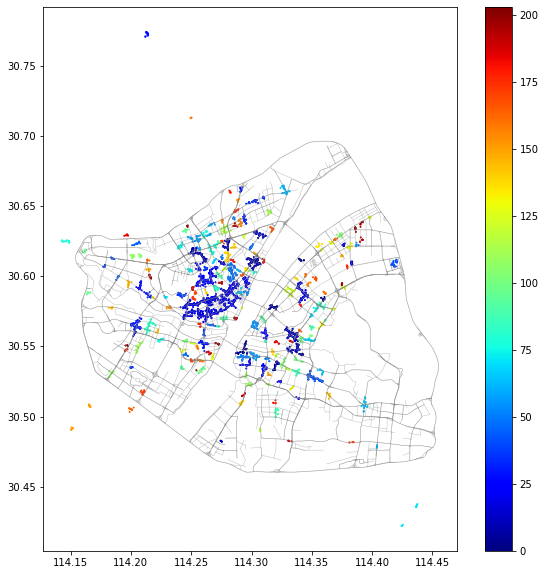

In [11]:
import geopandas as gpd

cluster_gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df['经度'], filtered_df['纬度']))
track_ax = cluster_gdf.plot(column='热点类别',cmap='jet',legend=True,markersize=1,figsize=(10,10))  # 必要的绘图设置
wuhan_road = gpd.GeoDataFrame.from_file('data/road/WHroad.shp')  # 叠加武汉市路网
wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')

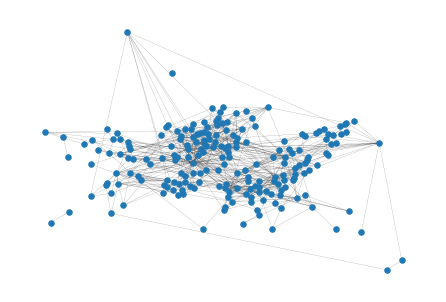

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import csv

def get_nodes(df):
    '''
    节点的属性列表包含了热点的ID、经度、纬度以及访问的频次
    '''
    node_ids = list(set(df['热点类别'].tolist()))
    nodes = [[ids] for ids in node_ids]
    node_count = df['热点类别'].value_counts()
    for node in nodes:node.append({'Node_ID':node[0], 'AverLon':round(df[df['热点类别']==node[0]]['经度'].mean(),6),
                                   'AverLat':round(df[df['热点类别']==node[0]]['纬度'].mean(),6), 'counts': node_count[node[0]]})
   
    #获取节点文件csv
    # header = ['Node_ID','AverLon','AverLat','counts'] #数据列名
    # values=[[ids] for ids in node_ids]
    # for node in values:node.append((node[0]))
    # for node in values:node.append(round(df[df['热点类别']==node[0]]['经度'].mean(),6))
    # for node in values:node.append(round(df[df['热点类别']==node[0]]['纬度'].mean(),6))
    # for node in values:node.append(node_count[node[0]])
    # with open(f'data\\result\\node.csv','w',encoding='utf-8',newline='')as f:
    #     writer=csv.writer(f)
    #     writer.writerow(headers)
    #     writer.writerows(values)
    return nodes

def get_edges(df):
    
    ids = list(set(df['热点类别'].tolist()))  # 求出热点类数
    edges = {}  # 类似于邻接矩阵
    for i in range(0, len(ids)):
        for j in range(i, len(ids)): edges[(i,j)] = 0
    #print(edges)
    n = 0
    while n < len(df) - 1:
        #print((df.at[n, '热点类别'], df.at[n+1, '热点类别']))
        e1=(df.at[n, '热点类别'], df.at[n+1, '热点类别'])
        e2=(df.at[n+1, '热点类别'], df.at[n, '热点类别'])
        if e1 in edges: edges[e1] += 1
        if e2 in edges: edges[e2] += 1
        n += 2
    edge_list = []  # NetworkX要求的带权边是“三元组”的形式，即(起点, 终点, 权重)
    for key in edges:
        if key[0] != key[1] and edges[key]>0: edge_list.append((key[0], key[1], edges[key]))  # NetworkX有的算法要求不能有self-loop（自循环）
        
    return edge_list

def paint_network(G, nodes):#绘制网络
    pos_dict = {}
    for node in nodes:
        pos_dict[node[0]] = (node[1]['AverLon'], node[1]['AverLat'])  # 以点的经纬度作为绘制的坐标
    nx.draw(G, node_size=30, pos = pos_dict, width = 0.1)
    plt.show()

nodes = get_nodes(filtered_df)
edges = get_edges(filtered_df)
#获取连边文件csv
# header = ['edgeNode1', 'edgeNode2', 'numCount'] #数据列名
# test=pd.DataFrame(columns=header,data=edges)#数据有三列，列名分别为one,two,three
# test.to_csv('data//result//edge.csv',encoding='gbk')   
G = nx.Graph()  # 开始构建空网络
G.add_nodes_from(nodes)  # 分别填入节点和边到网络中
G.add_weighted_edges_from(edges)
paint_network(G, nodes)  # 对网络进行拓扑可视化展示

{0: 14, 1: 4, 2: 4, 3: 4, 4: 4, 5: 20, 6: 15, 7: 45, 8: 23, 9: 59, 10: 54, 11: 26, 12: 2, 13: 19, 14: 13, 15: 4, 16: 1, 17: 43, 18: 249, 19: 22, 20: 13, 21: 5, 22: 5, 23: 20, 24: 15, 25: 119, 26: 15, 27: 9, 28: 4, 29: 15, 30: 33, 31: 10, 32: 8, 33: 16, 34: 3, 35: 6, 36: 4, 37: 11, 38: 8, 39: 5, 40: 5, 41: 19, 42: 24, 43: 8, 44: 5, 45: 3, 46: 12, 47: 9, 48: 57, 49: 8, 50: 3, 51: 20, 52: 4, 53: 11, 54: 3, 55: 22, 56: 25, 57: 24, 58: 8, 59: 1, 60: 7, 61: 7, 62: 4, 63: 17, 64: 7, 65: 5, 66: 16, 67: 9, 68: 20, 69: 7, 70: 6, 71: 2, 72: 2, 73: 7, 74: 11, 75: 8, 76: 12, 77: 10, 78: 5, 79: 15, 80: 8, 81: 8, 82: 12, 83: 19, 84: 4, 85: 13, 86: 4, 87: 9, 88: 3, 89: 8, 90: 13, 91: 4, 92: 15, 93: 10, 94: 6, 95: 5, 96: 5, 97: 1, 98: 1, 99: 14, 100: 6, 101: 9, 102: 8, 103: 11, 104: 6, 105: 4, 106: 5, 107: 9, 108: 4, 109: 13, 110: 13, 111: 8, 112: 10, 113: 3, 114: 20, 115: 2, 116: 5, 117: 3, 118: 7, 119: 6, 120: 4, 121: 22, 122: 6, 123: 4, 124: 6, 125: 4, 126: 3, 127: 4, 128: 7, 129: 7, 130: 3, 131: 9,

<Figure size 1800x1200 with 0 Axes>

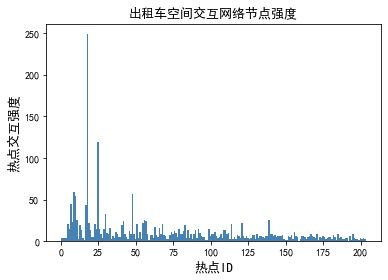

In [13]:
import matplotlib as mpl

strength=dict(G.degree(weight='weight'))#计算节点强度
print(strength)

mpl.rcParams["font.sans-serif"] = ["SimHei"]  # 让matplotlib支持中文字体的显示
plt.figure(dpi=300)  # 设置绘图的分辨率，默认绘制的图形不够清晰

X=[i for i in range(0,len(strength))][1:]
Y=[strength[key] for key in strength][1:]  # 设置绘制的数据——空间交互网络节点强度
fig = plt.figure()
plt.bar(X,Y,1,color="steelblue")
plt.xlabel("热点ID",fontsize=13)
plt.ylabel("热点交互强度",fontsize=13)
#plt.grid(True)
plt.title("出租车空间交互网络节点强度",fontsize=13)
plt.show() 

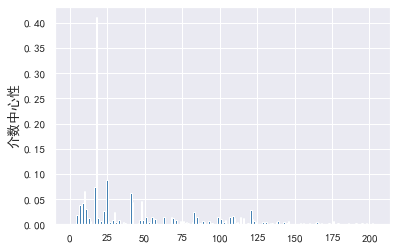

In [60]:
node_bet_centralities = dict(nx.betweenness_centrality(G))

X=[i for i in range(0,len(node_bet_centralities))][1:]
Y=[node_bet_centralities[key] for key in node_bet_centralities][1:]  # 设置绘制的数据——空间交互网络节点强度
fig = plt.figure()
plt.bar(X,Y,1,color="steelblue")
plt.ylabel("介数中心性",fontsize=13)
#plt.grid(True)
plt.show() 

nodes number = 204
edges number = 755
average degree = 7.401960784313726
density = 0.03646286100647155
average clustering = 0.2855124109000005
graph is not connected
degree assortativity coefficient = -0.13548281483892335


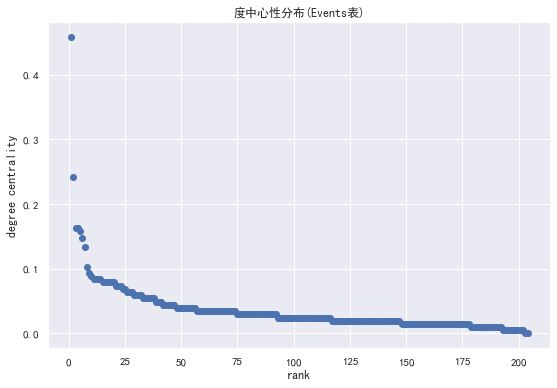

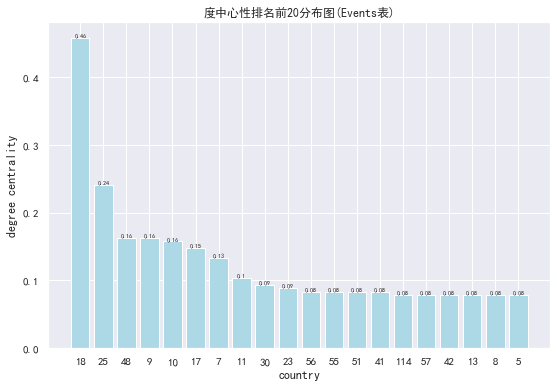

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

# 绘图配色
sns.set(color_codes=True)
imgPath = 'data/result/img/'
# 输出网络基本测度信息
def graphAttr(graph):
    print('nodes number = ' + str(graph.number_of_nodes()))  # 输出网络节点数
    print('edges number = ' + str(graph.number_of_edges()))  # 输出网络连边数
    deg = nx.degree(graph)
    degSum = 0
    for degree in deg:
        degSum += degree[1]
    degAver = degSum / len(deg)
    print('average degree = ' + str(degAver))  # 输出平均度
    print('density = ' + str(nx.density(graph)))  # 输出网络密度
    print('average clustering = ' + str(nx.average_clustering(graph, count_zeros=True)))  # 输出平均聚类系数
    try:
        print('average shortest path length = ' + str((nx.average_shortest_path_length(graph))))  # 输出网络平均路径长度
    except:
        print('graph is not connected')  # 当网络并非完全连接时，网络平均路径长度无法计算
    print('degree assortativity coefficient = ' + str(nx.degree_assortativity_coefficient(graph)))  # 度同配性
    
    # 观察度中心性分布
def nodedc(graph):
    dc = nx.degree_centrality(graph)
    dcsort = zip(dc.values(), dc.keys())
    dcsort = sorted(dcsort, reverse=True)
    dcsort = pd.DataFrame(dcsort)
    rank = np.arange(len(dcsort)) + 1  # 利用排名作为横坐标，度中心性值作为纵坐标
    plt.figure(figsize=(9, 6))
    plt.scatter(rank, dcsort[0])  # 绘制散点图
    plt.ylabel('degree centrality')
    plt.xlabel('rank')
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负数
    plt.title('度中心性分布(Events表' + ')')
    plt.savefig(imgPath + 'node_centrality'  + '.png', dpi=300, bbox_inches='tight')  # 保存为图片
    
    # # 观察度中心性前20
    dcsort20 = dcsort.head(20)  # 提取排名前20的热点
    plt.figure(figsize=(9, 6))
    plt.bar(x=dcsort20.index, height=dcsort20[0], width=0.8, color="lightblue")  # 绘制柱状图
    plt.xticks(range(20), dcsort20[1])  
    plt.ylabel('degree centrality')
    plt.xlabel('country')
    plt.title('度中心性排名前20分布图(Events表' + ')')
    for indexs, num in zip(dcsort20.index, dcsort20[0]):  # 显示数据标签
        plt.text(indexs, num, round(num, 2), ha='center', va='bottom', fontsize=6)
    plt.savefig(imgPath + 'node_centrality20' + '.png', dpi=300, bbox_inches='tight')
    
graphAttr(G)  # 运行网络测度函数
nodedc(G)  # 运行度中心性函数

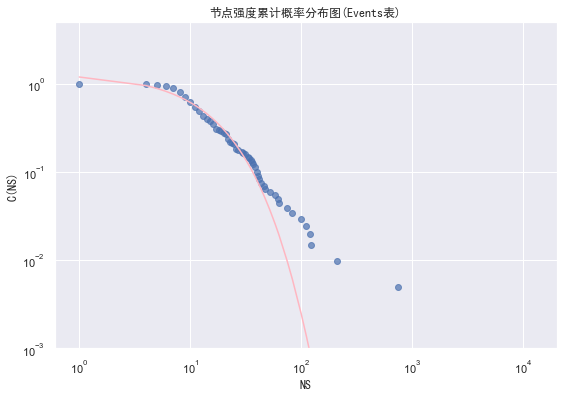

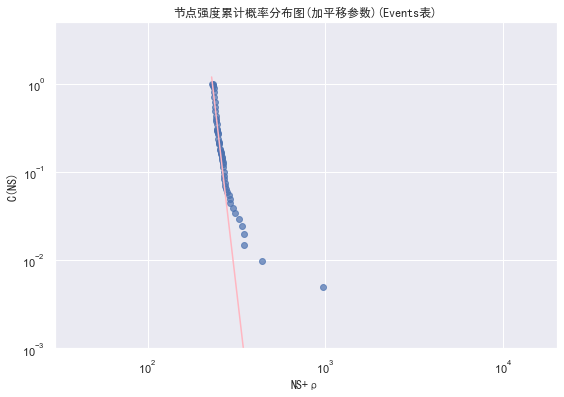

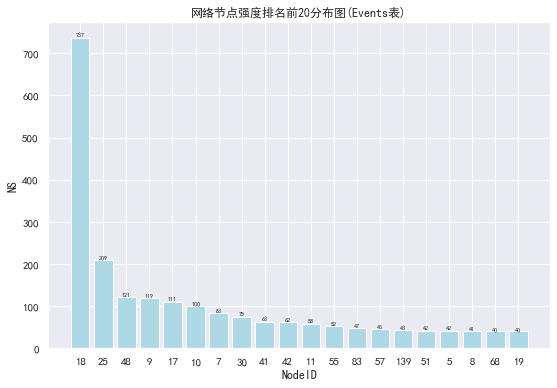

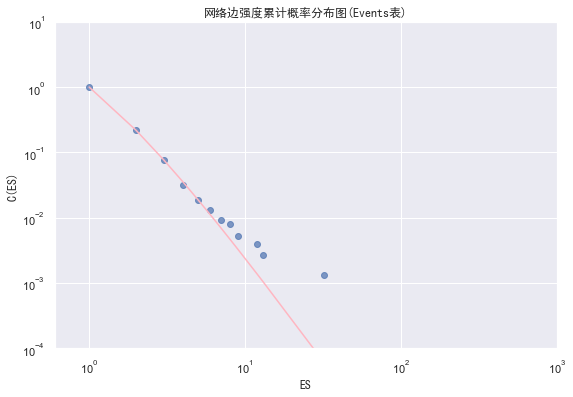

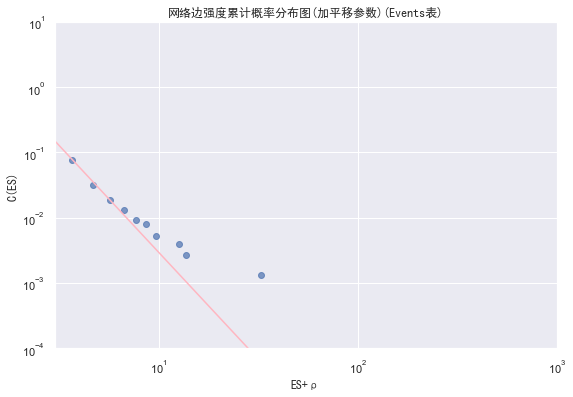

In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from collections import Counter

imgPath = 'data/result/img/'
# 获取数据
nodeList = pd.read_csv('data//result//node.csv')
edgeList = pd.read_csv('data//result//edge.csv')
nodeList.columns = ['node','AverLon','AverLat','numCount']
edgeList.columns = ['edgeNode1', 'edgeNode2', 'numCount']

# 按频率排序
nodeSort = nodeList.sort_values(by=['numCount'], ascending=False)  # 对节点强度进行排序
nodeCountData = list(nodeSort['numCount'])  # 单独拿出排序好的节点强度数值
edgeSort = edgeList.sort_values(by=['numCount'], ascending=False)  # 对边强度进行排序
edgeCountData = list(edgeSort['numCount'])  # 单独拿出排序好的边强度数值

# 关于绘图的一些设置
sns.set(color_codes=True)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负数


# 定义函数
def Zipf(x, a, b, c):
    return a * pow(x + b, -c)


# 用zipf-Mandelbrot定律拟合，返回拟合值
def zipfMandFit(FreqCount):
    popt, pcov = curve_fit(Zipf, FreqCount.num, FreqCount.cumulative,maxfev=500000)
    a = popt[0]
    b = popt[1]
    c = popt[2]
    yvals = Zipf(FreqCount.num, a, b, c)
    return yvals, b, c


# 计算各数值的互补累计概率
def cumuCalculate(CountData):
    cnt = Counter(map(float, CountData))  # 对不同数值的出现次数进行统计
    FreqCount = pd.DataFrame(columns=['num', 'numCount'])
    for num, numCount in cnt.items():  # 将频率数值和该数值出现的次数组成一个数据框
        FreqCount = FreqCount.append({'num': num, 'numCount': numCount}, ignore_index=True)
    FreqCount = FreqCount.sort_values(by=['num'], ascending=False)  # 按频率数值大小进行排序
    FreqCount['cumulative'] = FreqCount['numCount'].cumsum() / len(CountData)  # 计算累计概率
    return FreqCount


# 绘制节点强度累计概率分布图
def nodeCumu():
    nodeFreqCount = cumuCalculate(nodeCountData)  # 计算累计概率

    plt.figure(figsize=(9, 6))
    ax = plt.gca()
    ax.set_xscale("log")  # 设置x轴为对数坐标
    ax.set_yscale("log")  # 设置y轴为对数坐标
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Arial') for label in labels]  # 设置刻度值字体
    plt.scatter(nodeFreqCount['num'], nodeFreqCount['cumulative'], alpha=0.7)
    plt.xlim(1e-1 + 0.5, 1e5 - 80000)  # 设置x轴坐标范围 ! 注意这里的数值范围要根据实际情况进行调整
    plt.ylim(1e-3, 1e1 - 5)  # 设置y轴坐标范围 ! 注意这里的数值范围要根据实际情况进行调整

    yvals, b, c = zipfMandFit(nodeFreqCount)  # 用Zip函数拟合获取返回值

    plt.plot(nodeFreqCount.num, yvals, color="lightpink")  # 绘制拟合曲线
    plt.ylabel('C(NS)')
    plt.xlabel('NS')
    plt.title('节点强度累计概率分布图(Events表'  + ')')
    plt.savefig(imgPath + 'node_cumuLog'  + '.png', dpi=300, bbox_inches='tight')

    # ---------------------------下面是绘制加平移参数后的图--------------------------------
    plt.figure(figsize=(9, 6))
    ax = plt.gca()
    ax.set_xscale("log")  # 设置x轴为对数坐标
    ax.set_yscale("log")  # 设置y轴为对数坐标
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Arial') for label in labels]  # 设置刻度值字体
    plt.scatter(nodeFreqCount['num'] + b, nodeFreqCount['cumulative'], alpha=0.7)
    plt.xlim(1e1 + 20, 1e5 - 80000)  # 设置x轴坐标范围 ! 注意这里的数值范围要根据实际情况进行调整
    plt.ylim(1e-3, 1e1 - 5)  # 设置y轴坐标范围 ! 注意这里的数值范围要根据实际情况进行调整

    plt.plot(nodeFreqCount.num + b, yvals, color="lightpink")  # 绘制拟合曲线
    plt.ylabel('C(NS)')
    plt.xlabel('NS+ρ')
    plt.title('节点强度累计概率分布图(加平移参数)(Events表' + ')')
    plt.savefig(imgPath + 'node_cumuLog_trans_'  + '.png', dpi=300, bbox_inches='tight')


# 绘制节点强度前20分布图
def node20():
    node20 = nodeSort.head(20).reset_index(drop=True)
    plt.figure(figsize=(9, 6))
    plt.bar(x=node20.index, height=node20['numCount'], width=0.8, color="lightblue")
    plt.xticks(range(20), node20['node'])  # X轴标签
    plt.ylabel('NS')
    plt.xlabel('NodeID')
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    for indexs, num in zip(node20.index, node20['numCount']):  # 显示数据标签
        plt.text(indexs, num, '%.0f' % num, ha='center', va='bottom', fontsize=6)
    plt.title('网络节点强度排名前20分布图(Events表'  + ')')
    plt.savefig(imgPath + 'node_Freq20' + '.png', dpi=300, bbox_inches='tight')

# 绘制边强度累计频率分布图
def edgeCumu():
    edgeFreqCount = cumuCalculate(edgeCountData)  # 计算累计频率

    plt.figure(figsize=(9, 6))
    ax = plt.gca()
    ax.set_xscale("log")  # 设置x轴为对数坐标
    ax.set_yscale("log")  # 设置y轴为对数坐标
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Arial') for label in labels]  # 设置刻度值字体
    plt.scatter(edgeFreqCount['num'], edgeFreqCount['cumulative'], alpha=0.7)
    plt.xlim(1e-1 + 0.5, 1e3)  # 设置x轴坐标范围 ! 注意这里的数值范围要根据实际情况进行调整
    plt.ylim(1e-4, 1e1)  # 设置y轴坐标范围 ! 注意这里的数值范围要根据实际情况进行调整

    yvals, b, c = zipfMandFit(edgeFreqCount)  # 用Zip函数拟合获取返回值

    plt.plot(edgeFreqCount.num, yvals, color="lightpink")  # 绘制拟合曲线
    plt.ylabel('C(ES)')
    plt.xlabel('ES')
    plt.title('网络边强度累计概率分布图(Events表' + ')')
    plt.savefig(imgPath + 'edge_cumuLog_' + '.png', dpi=300, bbox_inches='tight')

    # ---------------------------下面是绘制加平移参数后的图--------------------------------
    plt.figure(figsize=(9, 6))
    ax = plt.gca()
    ax.set_xscale("log")  # 设置x轴为对数坐标
    ax.set_yscale("log")  # 设置y轴为对数坐标
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Arial') for label in labels]  # 设置刻度值字体
    plt.scatter(edgeFreqCount['num'] + b, edgeFreqCount['cumulative'], alpha=0.7)
    plt.xlim(3, 1e3)  # 设置x轴坐标范围 ! 注意这里的数值范围要根据实际情况进行调整
    plt.ylim(1e-4, 1e1)  # 设置y轴坐标范围 ! 注意这里的数值范围要根据实际情况进行调整

    plt.plot(edgeFreqCount.num + b, yvals, color="lightpink")  # 绘制拟合曲线
    plt.ylabel('C(ES)')
    plt.xlabel('ES+ρ')
    plt.title('网络边强度累计概率分布图(加平移参数)(Events表' + ')')
    plt.savefig(imgPath + 'edge_cumuLog_trans_'  + '.png', dpi=300, bbox_inches='tight')

# 绘制边强度前20连边分布图
# def edge20():
#     edge20 = edgeSort.head(20).reset_index(drop=True)
#     edgePair = []
#     for indexs in edge20.index:
#         edgePair.append(edge20.edgeNode1[indexs].rstrip() + '\n' + edge20.edgeNode2[indexs].strip())
#     plt.figure(figsize=(9, 6))
#     plt.bar(x=edge20.index, height=edge20['numCount'], width=0.8, color="lightblue")
#     plt.xticks(range(20), edgePair)  # X轴标签
#     plt.ylabel('ES')
#     plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
#     plt.title('网络边强度排名前20分布图(Events表' + ')')
#     for indexs, num in zip(edge20.index, edge20['numCount']):  # 显示数据标签
#         plt.text(indexs, num, '%.0f' % num, ha='center', va='bottom', fontsize=6)
#     plt.savefig(imgPath + 'edge_Freq20'  + '.png', dpi=300, bbox_inches='tight')


# 运行上面的函数
nodeCumu()
node20()

edgeCumu()
# edge20()

In [17]:
from networkx.algorithms import community

def gn_community_detect(g):  # 以NetworkX实现封装的社区检测算法为基础，初步探索复杂网络中的社团结构发现与分析方法
    comp = community.greedy_modularity_communities(g,weight='weight')
    graph_community = tuple(sorted(c) for c in comp)
    node_community={}
    cid=1
    for c in graph_community:
        for v in c:
            node_community[v]=cid
        cid+=1
    return graph_community,node_community

OD_Community1,node_community = gn_community_detect(G)  # 获取社区的划分结果
print('社区划分的个数：' + str(len(OD_Community1)) + '\n\n各个社区的所属：')
for c in OD_Community1: print(c)

社区划分的个数：10

各个社区的所属：
[7, 8, 9, 13, 14, 18, 19, 25, 28, 32, 33, 34, 35, 43, 46, 48, 49, 52, 53, 57, 58, 60, 61, 62, 63, 66, 67, 73, 74, 77, 79, 80, 81, 91, 92, 95, 112, 114, 118, 136, 137, 139, 140, 147, 156, 167, 169, 170, 175, 178, 182, 183, 193, 195, 196, 197, 201]
[0, 3, 4, 5, 10, 11, 20, 21, 22, 23, 26, 42, 50, 51, 55, 56, 64, 65, 68, 69, 76, 86, 87, 88, 89, 96, 100, 101, 103, 105, 110, 111, 113, 115, 117, 125, 131, 132, 138, 141, 143, 149, 172, 179, 181, 185, 187, 189, 190]
[1, 2, 6, 15, 16, 17, 41, 54, 59, 85, 93, 104, 121, 122, 123, 124, 129, 130, 133, 134, 135, 146, 157, 161, 162, 166, 168, 176, 180, 191, 198, 199, 202]
[12, 27, 29, 30, 36, 38, 47, 71, 72, 75, 83, 94, 99, 102, 108, 109, 120, 126, 127, 128, 142, 144, 148, 154, 158, 164, 171, 173, 177, 188, 194, 203]
[24, 31, 37, 39, 40, 44, 45, 70, 78, 106, 107, 145, 163, 174, 184, 186]
[82, 84, 90, 116, 119, 152, 153, 155, 160, 165, 200]
[97, 98]
[150, 151]
[159]
[192]


In [18]:
for index, row in filtered_df.iterrows():
    v=row['热点类别']
    filtered_df.loc[index,'热点社区']=node_community[v]

<AxesSubplot:>

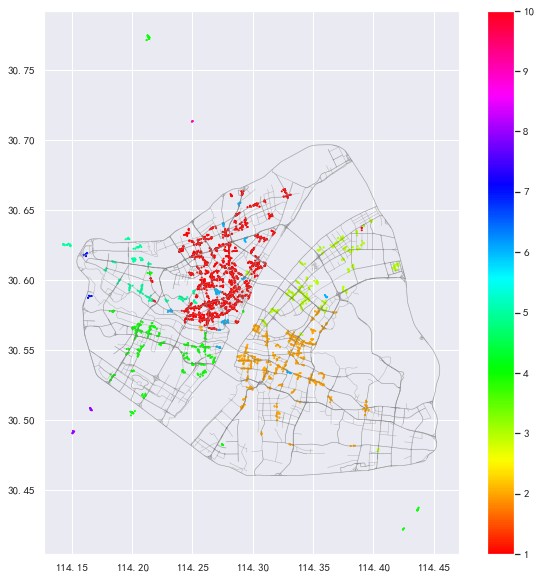

In [19]:
community_gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df['经度'], filtered_df['纬度']))
track_ax = community_gdf.plot(column='热点社区',cmap='hsv',legend=True,markersize=1,figsize=(10,10))  # 必要的绘图设置
wuhan_road = gpd.GeoDataFrame.from_file('data/road/WHroad.shp')  # 叠加武汉市路网
wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')